In [248]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import asf_search as asf
from collections import defaultdict
import datetime
import pickle
from tqdm import tqdm
from functools import reduce
import itertools
import operator
import lxml
import matplotlib.pyplot as plt
import matplotlib as mpl

In [249]:
#Extracts the data from the dataset ds that overlaps with the time filter and contains valid data for all columns in coumn_names
def valid_data_extraction(ds, time_filter, colum_names):
    #Make sure colum_names is a list
    if type(colum_names) is str:
        colum_names = [colum_names]
        
    #Not all column names found
    if not all([c in ds.data_vars for c in colum_names]):
        return None

    #Filter for time of interest and depth 0
    if type(time_filter) is tuple:
        ds = ds.sel(TIME=slice(time_filter[0], time_filter[1]), DEPTH=0)
    else:
        ds = ds.sel(TIME=time_filter, DEPTH=0)
    
    #Filter only avalible columns
    colum_names = list(set(colum_names).intersection(list(ds.data_vars)))
    colum_names_qc = [c + '_QC' for c in colum_names]
    
    #Filter for columns of interest
    ds = ds[colum_names + colum_names_qc]
    
    df = ds.to_dataframe()
    QC_good = [1.0, 7.0]
    
    #Filter for good data only
    filter_qc = [df[c_qc].isin(QC_good) for c_qc in colum_names_qc]
    #Element-wise AND the qc filters
    filter_qc = reduce(operator.and_, filter_qc)
    df = df[filter_qc][colum_names]
    
    return df

In [250]:
#Plots a histogram of the average difference between the VHM0 and VAVH parameters
#X axis is diveded in wave height as either VHM0, VAVH or the mean of the two,
#this is specified with the waveheight argument
def plot_wave_height_diff(df, waveheight='mean'):
    df=df.copy()
    #Round the column used to group-by
    df['wh_round'] = df[waveheight].round(decimals=1)
    #Group by and calculate the mean and count on the diff column
    plot_data = df.groupby(by='wh_round')['abs_diff'].agg(['mean', 'count'])
    #Add a count frequency column, the proportion of the datapoints that belong to this waveheight
    plot_data['count_freq'] = plot_data['count'] / plot_data['count'].sum()

    #Add a normalized count frequency column, this is used to index the color map
    min_freq = plot_data['count_freq'].min()
    max_freq = plot_data['count_freq'].max()
    color_map = plt.get_cmap('viridis')
    normalizer = plt.Normalize(min_freq, max_freq)
    plot_data['color_index'] = normalizer(plot_data['count_freq'])

    #Add a color column based on the color index
    plot_data['color'] = plot_data['color_index'].apply(lambda x: color_map(x))

    #Create the plot
    fig, ax = plt.subplots()
    ax.bar(plot_data.index, plot_data['mean'], color=plot_data['color'], align='edge', width=0.1)
    ax.set_ylabel("Average difference between VHM0 and VAVH")
    ax.set_xlabel("Waveheight (" + waveheight + ")")
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=color_map)
    fig.colorbar(sm, ax=ax)
    plt.show()

In [251]:
data_dir = '/data/exjobb/sarssw/bouy/data'
file_prefixes = ['NO_TS_MO', 'BO_TS_MO']
start_date = '2000-01-01'
end_date = '2021-12-31'
variables = ['VHM0', 'VAVH',]
max_time_diff_s = 15*60

#Variables where the results are saved
result_df = None

files = [f for f in os.listdir(data_dir) if any([f.startswith(fp) for fp in file_prefixes])]
#print(files)

for file in tqdm(files):
    ds = xr.open_dataset(os.path.join(data_dir, file))
    df_filtered = valid_data_extraction(ds, (start_date, end_date), variables)

    #If we got a result
    if df_filtered is not None:
        #extend the dataframe with filename added as index
        df_filtered['file'] = file
        df_filtered = df_filtered.set_index(['file'], append=True)
        #Add mean value of VAVH and VHM0
        df_filtered['mean'] = (df_filtered['VAVH'] + df_filtered['VHM0'])/2
        #Add differense between VAVH and VHM0
        df_filtered['abs_diff'] = np.abs(df_filtered['VAVH'] - df_filtered['VHM0'])
        df_filtered['diff'] = (df_filtered['VAVH'] - df_filtered['VHM0'])
        
        #Save result
        if result_df is None:
            result_df = df_filtered
        else:
            result_df = pd.concat([result_df, df_filtered])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:42<00:00,  1.13s/it]


In [252]:
result_df

,,VAVH,VHM0,mean,diff
TIME,file,,,,
2011-05-19 08:20:00.000000000,NO_TS_MO_Europlatform2.nc,0.52,0.51,0.515,0.01
2011-05-19 08:30:00.000000000,NO_TS_MO_Europlatform2.nc,0.50,0.49,0.495,0.01
2011-05-19 08:39:59.999999744,NO_TS_MO_Europlatform2.nc,0.46,0.44,0.450,0.02
2011-05-19 08:50:00.000000000,NO_TS_MO_Europlatform2.nc,0.47,0.45,0.460,0.02
2011-05-19 09:00:00.000000000,NO_TS_MO_Europlatform2.nc,0.48,0.46,0.470,0.02
...,...,...,...,...,...
2021-12-31 23:10:00.000000000,NO_TS_MO_AWG.nc,0.70,0.79,0.745,-0.09
2021-12-31 23:20:00.000000000,NO_TS_MO_AWG.nc,0.67,0.76,0.715,-0.09
2021-12-31 23:30:00.000000000,NO_TS_MO_AWG.nc,0.68,0.78,0.730,-0.10


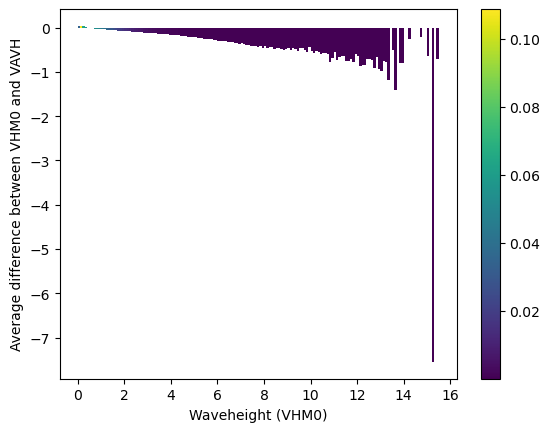

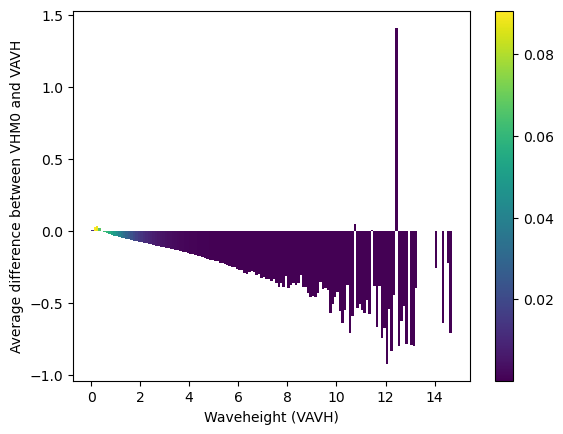

In [253]:
plot_wave_height_diff(result_df[result_df['VHM0'] <= 100], 'VHM0')
plot_wave_height_diff(result_df[result_df['VAVH'] <= 100], 'VAVH')
